# Pulse Profiles: Introductory Tutorial 3

This notebook will build on the previous tutorials, showing more features of the `PsrSigSim`. Details will be given for new features, while other features have been discussed in the previous tutorial notebook. This notebook shows the details of different methods of defining pulse profiles for simulated pulsars. This is useful for simulating realisitic pulse profiles and pulse profile evolution (with observing frequency.) 

We again simulate precision pulsar timing data with high signal-to-noise pulse profiles in order to clearly show the input pulse profile in the final simulated data product.

In [1]:
# import some useful packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# import the pulsar signal simulator
import psrsigsim as pss

## Setting up the Folded Signal

Here we will again set up the folded signal class as in the second introductory tutorial. We will again simulate a 20 minute long observation total, with subintegrations of 1 minute. The other simulation parameters will be 64 frequency channels each 12.5 MHz wide (for 800 MHz bandwidth) observed with the Green Bank Telescope at L-band (1500 MHz center frequency).

However, as part of this tutorial, we will simulate a real pulsar, J1713+0747, as we have a premade profile for this pulsar. The period, dm, and other relavent pulsar parameters come from the NANOGrav 11-yr data release.

In [4]:
# Define our signal variables.
f0 = 1500 # center observing frequecy in MHz
bw = 800.0 # observation MHz
Nf = 64 # number of frequency channels
# We define the pulse period early here so we can similarly define the frequency
period = 0.00457 # pulsar period in seconds for J1713+0747
f_samp = (1.0/period)*2048*10**-6 # sample rate of data in MHz (here 2048 samples across the pulse period
sublen = 60.0 # subintegration length in seconds, or rate to dump data at
# Now we define our signal
signal_1713 = pss.signal.FilterBankSignal(fcent = f0, bandwidth = bw, Nsubband=Nf, sample_rate = f_samp,
                                          sublen = sublen, fold = True) # fold is set to `True`

## The ISM and Telescope

Here we set up `ISM` and `telescope` objects in the same way as in the previous tutorial. Since we can set these up in any order, we will do these first to better show the different pulse profiles later.

In [18]:
# Define the dispersion measure
dm =  15.921200 # pc cm^-3
# And define the ISM object, note that this class takes no initial arguements
ism_fold = pss.ism.ISM()

# We intialize the telescope object as the Green Bank Telescope
tscope = pss.telescope.telescope.GBT()

## Pulse Profiles

In previous tutorials, we have defined a very simple Gaussian profile as the pulse profile. However, the `PsrSigSim` allows users to define profiles in a few different ways, including multiple Gaussians, a user input profile in the form of a Python array, and two-dimensional versions of the pulse profiles called pulse portaits.

We will go through a few different ways to set up the pulse profiles, and then will simulate different initial pulsars and the subsequent data, through the full pipeline.

### Gaussian Profiles

The first method is the Gaussian profile, which has been demonstrated in previous tutorials. The Guassian needs three parameters, an amplitude, a width (or sigma), and a peak, the center of the Gaussian in phase space (e.g. 0-1). The simplest profile that can be defined is a single Gaussian.

In [22]:
gauss_prof = pss.pulsar.GaussProfile(peak = 0.25, width = 0.01, amp = 1.0)

Defining the profile just tells the simulator how to make the pulses. If we want to see what they look like, we need to initialize the profile, and then we can give it a number of phase bins and plot it.

In [23]:
# We want to use 2048 phase bins and just one frequency channel for this test.
gauss_prof.init_profiles(2048, Nchan = 1)

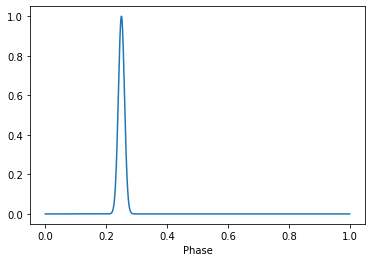

In [24]:
# And then we can plot the array to see what the profile looks like
plt.plot(np.linspace(0,1,2048), gauss_prof.profiles[0])
plt.xlabel("Phase")
plt.show()
plt.close()

However the Gaussian profile can also be used to make a pulse profile with multiple Gaussian components. Instead of inputting a single value into each of the three fields (peak, width, amp), we input an array of the corresponding values, e.g. the second value in each array are the components of the second Gaussian component. Below we build on the previous single Gaussian profile by adding a small "shoulder" to the main pulse profile, as well as a broad interpulse to the profile.

Note - curently the input for multiple Gaussian components must be an array, it cannot be a list.

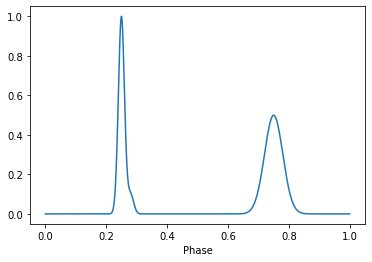

In [39]:
# Define the number and value of each Gaussain component
peaks = np.array([0.25, 0.28, 0.75])
widths = np.array([0.01, 0.01, 0.03])
amps = np.array([1.0, 0.1, 0.5])

# Define the profile using multiple Gaussians
multi_gauss_prof = pss.pulsar.GaussProfile(peak = peaks, width = widths, amp = amps)
# We want to use 2048 phase bins and just one frequency channel for this test.
multi_gauss_prof.init_profiles(2048, Nchan = 1)
# And then we can plot the array to see what the profile looks like
plt.plot(np.linspace(0,1,2048), multi_gauss_prof.profiles[0])
plt.xlabel("Phase")
plt.show()
plt.close()

### Data Profiles

The PsrSigSim can also take arrays of data points as the pulse profile in what is called a `DataProfile`. This array represents pulse profile and may be used to define the pulse profile shape. The number of bins in the input data profile does not need to be the equivalent to the input sampling rate. This option may be useful when simulating real pulsars or realistic pulsar data.

Here we will use a premade profile of the pulsar J1713+0747 as the pulse profile.

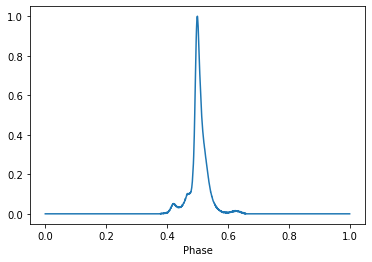

In [50]:
# First we load the data array
path = 'psrsigsim/data/J1713+0747_profile.npy'
J1713_dataprof = np.load(path)

# Now we define the data profile
J1713_prof = pss.pulsar.DataProfile(J1713_dataprof)
# Now we can initialize and plot the profile the same way as the Gaussian profile
J1713_prof.init_profiles(2048, Nchan = 1)
# And then we can plot the array to see what the profile looks like
plt.plot(np.linspace(0,1,2048), J1713_prof.profiles[0])
plt.xlabel("Phase")
plt.show()
plt.close()

### Data Portraits

While the `Profile` objects initialize a 1-D pulse profile, there are also `Portrait` objects that have the ability to initialize a 2-D pulse profile. A `Profile` object will use the same pulse profile for every simulated frequency channel, while a `Portrait` can use different versions of the profile at different frequencies. 

To illustrate this, we will initialize a pulse `Portrait` for J1713+0747 where they are scaled in power. We start by showing how a pulse `Profile` uses the same profile at every frequency, then how a `Portrait` is initialized, and finally, how different profiles may be input at each frequency using a pulse `Portrait`.

Using the same profile as above, we will initialize a multi-frequency profile, and show that it has the same shape and power at different frequencies.

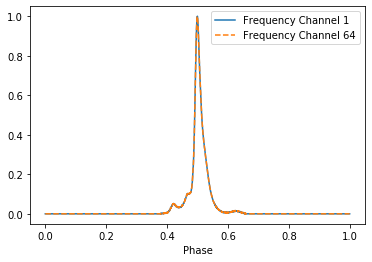

In [44]:
# Initialize a multi-channel profile
J1713_prof.init_profiles(2048, Nchan = 64)
# And then we can plot the array to see what the profile looks like
plt.plot(np.linspace(0,1,2048), J1713_prof.profiles[0], label = "Frequency Channel 1")
plt.plot(np.linspace(0,1,2048), J1713_prof.profiles[-1], ls = '--', label = "Frequency Channel 64")
plt.xlabel("Phase")
plt.legend(loc='best')
plt.show()
plt.close()

It is easy to see that the two profiles are identical. If we plot a 2-D image of the profile phase as a function of frequency channel, we can see that they are all identical.

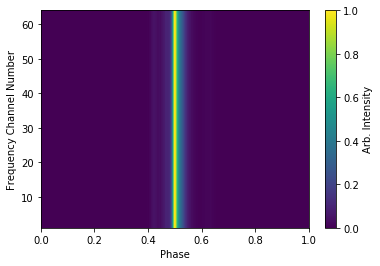

In [45]:
plt.imshow(J1713_prof.profiles, aspect = 'auto', interpolation='nearest', origin = 'lower', \
           extent = [0.0, 1.0, 1, 64])
plt.ylabel("Frequency Channel Number")
plt.xlabel("Phase")
plt.colorbar(label = "Arb. Intensity")
plt.show()
plt.close()

We can similarly initialize a pulse `Portait`. Here we will first create a multidimensional array of pulse profile, as well as an array to scale them by. We will then initialize a pulse `Portrait` object and show that the profiles generated retain the scaling.

In [52]:
# Make a 2-D array of the profiles
J1713_dataprof_2D = np.tile(J1713_dataprof, (64,1))
# Now we scale them linearly so that lower frequency channels are "brighter"
scaling = np.reshape(np.linspace(1.0, 0.1, 64), (64,1))
J1713_dataprof_2D *= scaling
# Now we make a `Portrait`
J1713_prof_2D = pss.pulsar.DataPortrait(J1713_dataprof_2D)
# Now we initialize the profiles
J1713_prof_2D.init_profiles(2048, 64)

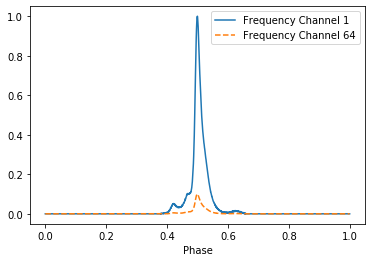

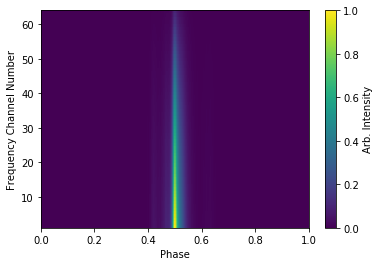

In [56]:
# Now we can plot the first and last profile, as well as the 2-D power of the input profiles at each frequency
# And then we can plot the array to see what the profile looks like
plt.plot(np.linspace(0,1,2048), J1713_prof_2D.profiles[0], label = "Frequency Channel 1")
plt.plot(np.linspace(0,1,2048), J1713_prof_2D.profiles[-1], ls = '--', label = "Frequency Channel 64")
plt.xlabel("Phase")
plt.legend(loc='best')
plt.show()
plt.close()
# And the 2-D image
plt.imshow(J1713_prof_2D.profiles, aspect = 'auto', interpolation='nearest', origin = 'lower', \
           extent = [0.0, 1.0, 1, 64])
plt.ylabel("Frequency Channel Number")
plt.xlabel("Phase")
plt.colorbar(label = "Arb. Intensity")
plt.show()
plt.close()

We can see that the generated profiles then retain the scaling they have been given. This is just a simplistic version of what can be done, using the `Portrait` class.

## Pulsars

Now we will set up a few different `Pulsar` classes and simulate the full dataset, showing how the input profiles are retained through the process of dispersion and adding noise to the simulated data.

In [57]:
# Define the values needed for the puslar
Smean = 0.009 # The mean flux of the pulsar, J1713+0747 at 1400 MHz from the ATNF pulsar catatlog, here 0.009 Jy
psr_name_1 = "J0000+0000" # The name of our simulated pulsar with a multi-gaussian profile
psr_name_2 = "J1713+0747" # The name of our simulated pulsar with a scaled, 2-D profile

# Now we define the pulsar with multiple Gaussians defining its profile
pulsar_mg = pss.pulsar.Pulsar(period, Smean, profiles=multi_gauss_prof, name = psr_name_1)

# Now we define the pulsar with the scaled J1713+0747 profiles
pulsar_J1713 = pss.pulsar.Pulsar(period, Smean, profiles=J1713_prof_2D, name = psr_name_2)

## Simulations

We run the rest of the simulation, including dispersion and "observing" with our telescope. The same parameters are used for both `Pulsar`s and simulated data sets with the only difference being the input profiles. We then show the results of each simulation and how they retain the initial input profile shapes.

We first run the simultion for our fake multi-gaussian profile pulsar.

In [59]:
# define the observation length
obslen = 60.0*20 # seconds, 20 minutes in total
# Make the pulses
pulsar_mg.make_pulses(signal_1713, tobs = obslen)
# Disperse the data
ism_fold.disperse(signal_1713, dm)
# Observe with the telescope
tscope.observe(signal_1713, pulsar_mg, system="Lband_GUPPI", noise=True)

98% dispersed in 0.122 seconds.

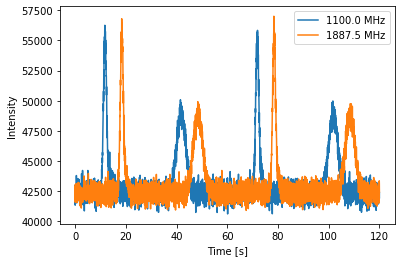

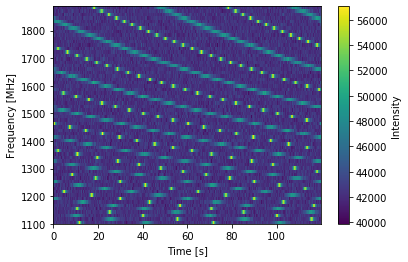

In [60]:
# Now we plot these profiles
# Get the phases of the pulse
time = np.linspace(0, obslen, len(signal_1713.data[0,:]))
# Since we know there are 2048 bins per pulse period, we can index the appropriate amount
plt.plot(time[:4096], signal_1713.data[0,:4096], label = signal_1713.dat_freq[0])
plt.plot(time[:4096], signal_1713.data[-1,:4096], label = signal_1713.dat_freq[-1])
plt.ylabel("Intensity")
plt.xlabel("Time [s]")
plt.legend(loc = 'best')
plt.show()
plt.close()

# And the 2-D plot
plt.imshow(signal_1713.data[:,:4096], aspect = 'auto', interpolation='nearest', origin = 'lower', \
           extent = [min(time[:4096]), max(time[:4096]), signal_1713.dat_freq[0].value, signal_1713.dat_freq[-1].value])
plt.ylabel("Frequency [MHz]")
plt.xlabel("Time [s]")
plt.colorbar(label = "Intensity")
plt.show()
plt.close()

It is clear that we have maintained the initial shape of this profile. Now we will do the same thing but with the scaled 2-D pulse `Portrait` pulsar.

In [62]:
# We first must redefine the input signal
signal_1713 = pss.signal.FilterBankSignal(fcent = f0, bandwidth = bw, Nsubband=Nf, sample_rate = f_samp,
                                       sublen = sublen, fold = True) # fold is set to `True`

# define the observation length
obslen = 60.0*20 # seconds, 20 minutes in total
# Make the pulses
pulsar_J1713.make_pulses(signal_1713, tobs = obslen)
# Disperse the data
ism_fold.disperse(signal_1713, dm)
# Observe with the telescope
tscope.observe(signal_1713, pulsar_J1713, system="Lband_GUPPI", noise=True)

98% dispersed in 0.115 seconds.

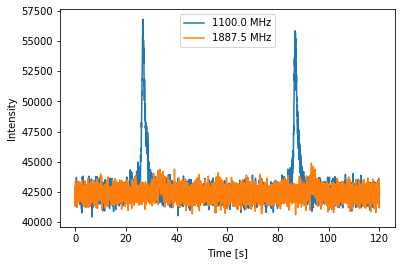

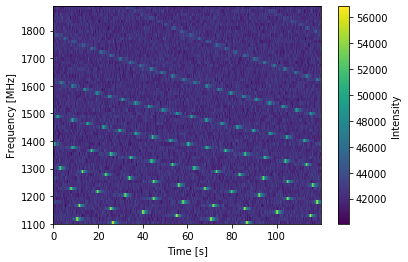

In [63]:
# Now we plot these profiles
# Get the phases of the pulse
time = np.linspace(0, obslen, len(signal_1713.data[0,:]))
# Since we know there are 2048 bins per pulse period, we can index the appropriate amount
plt.plot(time[:4096], signal_1713.data[0,:4096], label = signal_1713.dat_freq[0])
plt.plot(time[:4096], signal_1713.data[-1,:4096], label = signal_1713.dat_freq[-1])
plt.ylabel("Intensity")
plt.xlabel("Time [s]")
plt.legend(loc = 'best')
plt.show()
plt.close()

# And the 2-D plot
plt.imshow(signal_1713.data[:,:4096], aspect = 'auto', interpolation='nearest', origin = 'lower', \
           extent = [min(time[:4096]), max(time[:4096]), signal_1713.dat_freq[0].value, signal_1713.dat_freq[-1].value])
plt.ylabel("Frequency [MHz]")
plt.xlabel("Time [s]")
plt.colorbar(label = "Intensity")
plt.show()
plt.close()

Here it is clear the the scaling has also been maintained, with lower-frequency pulses being brighter than high-frequency pulses.